# Tecnicas de suavizado: promedio móvil y promedio móvil exponencial

### Carga de los datos

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
airline = pd.read_csv('airline_passengers.csv',
                      index_col='Month',
                      parse_dates=True)


In [ ]:
airline.head(10)

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [ ]:
len(airline)

144

In [ ]:
airline.dtypes

,0
Thousands of Passengers,int64


Observa como en la propia importación de datos hemos realizado dos operaciones básicas para trabajarlos como serie temporal:

1.- Establecer como índice la columna "Month"

2.- Convertir las columnas correspondientes a fecha.


In [ ]:
airline.dropna(inplace=True)

In [ ]:
len(airline)

144

In [ ]:
# Esto no es necesario en este caso, pero a tener en cuenta...
#df.index.freq = 'MS'
#df.index


### Promedio móvil simple

El promedio móvil simple lo que hace es calcular el valor futuro a partir del promedio de los n valores pasados.

$SMA=\frac{x_1+x_2+...+x_n}{n} $

donde $x_i$ son los valores de la variable, por tanto $SMA$ es un promedio aritmético de $n$ períodos atrás.

Lo que tenemos que hacer es seleccionar en primer lugar la ventana, que es el número de valores pasados que vamos a tener en cuenta para hacer el cálculo del promedio móvil simple

Por ejemplo, vamos a coger en primer lugar una ventana de 6 (es decir, 6 datos atrás en el tiempo). Y, una vez tenemos en cuenta esos 6 valores pasados, calculamos la media.
Para ello utilizamos `rolling()`

In [ ]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()

Rolling lo que permite es crear una ventana, un intervalo de valores, e ir desplazándose por la serie temporal para ir calculando los valores, y de ahí calcular la media con `mean()`

Podemos hacer lo mismo con una ventana de 12 elementos:

In [ ]:
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(
    window=12).mean()

In [ ]:
airline.head(15)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


Como ves, una de las desventajas de este método es que no puedes calcular valores hasta que no tienes toda la ventana completa, y esos valores se rellenan con NaN.

Vamos a visualizar ahora la serie temporal frente a las predicciones cogiendo las ventanas de 6 meses y de 12 meses.

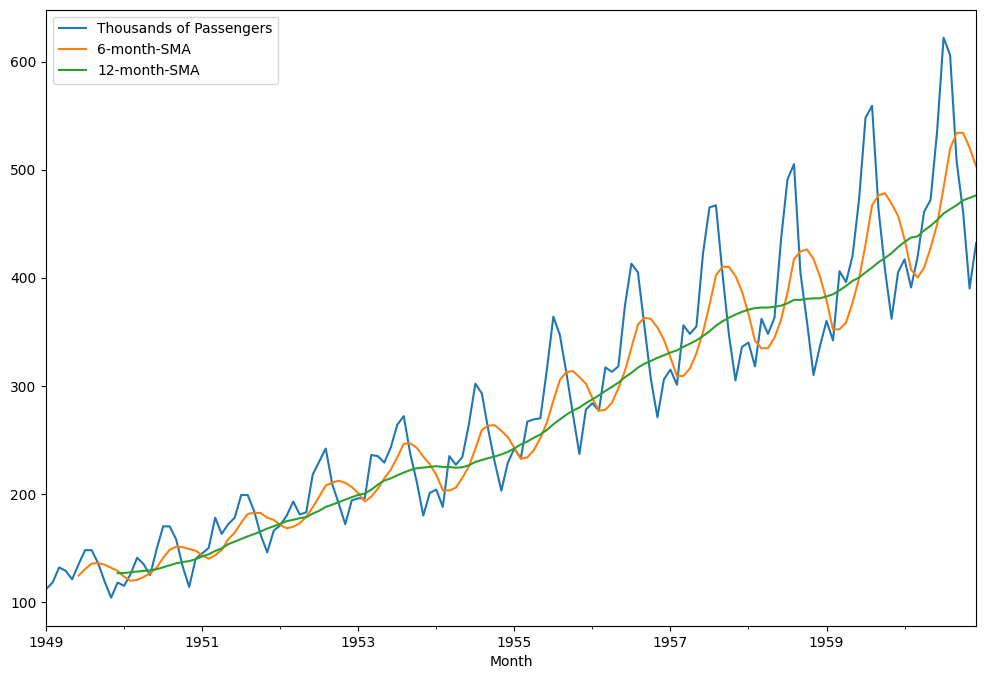

In [ ]:
airline.plot(figsize=(12,8));

Como ves, el resultado de las estimaciones es flojo desde un primer momento. Este modelo, al final, depende mucho de la ventana que se quiera elegir. Y además, le estamos dando al mismo peso a todos los valores pasados, tanto si es un mes anterior como si son 6 o 12 meses pasados. Para ponderar y que un valor inmediatamente pasado tenga más peso que uno que ya ha pasado hace mucho más tiempo, se utiliza el Promedio Móvil Ponderado.

### Promedio móvil ponderado exponencialmente



EWMA nos permitirá reducir el efecto de retraso del Promedio Móvil Simple y pondrá más peso en los valores que ocurrieron más recientemente. La cantidad de peso aplicada a los valores más recientes dependerá de los parámetros utilizados en EWMA, la fórmula con la que se calculan las estimaciones es:

 $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Para hacer el cálculo del Promedio Móvil Ponderado Exponencial en Python, utilizamos la función `ewm()`, que necesita de una serie de parámetros:     
- Adjust: Argumento booleano que lo que indica es la forma de la que se calculan los pesos.

  - Si adjust = true, las estimaciones se calculan como:
  $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

  - Si adjust = false, las estimaciones se calculan como:
  $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$



In [ ]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

Vamos ahora a visualizar los datos:

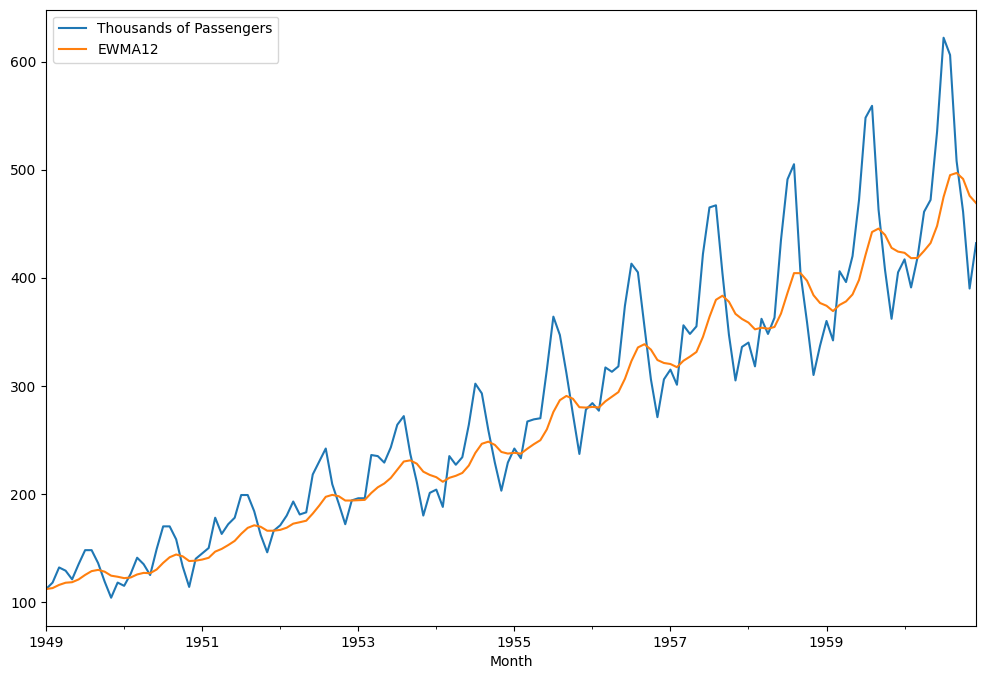

In [ ]:
airline[['Thousands of Passengers','EWMA12']].plot(figsize=(12,8));

## Comparación de SMA y EWMA

Podemos también hacer una comparación entre el Promedio Movil Simple y el Promedio Móvil Ponderado Exponencial:

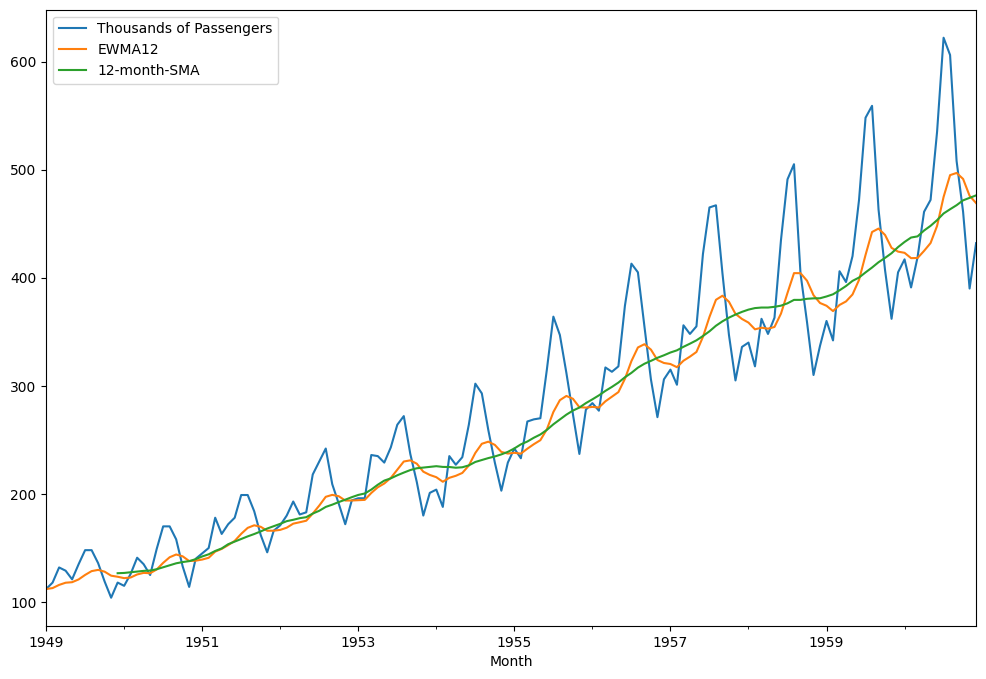

In [ ]:
airline[['Thousands of Passengers','EWMA12',
         '12-month-SMA']].plot(figsize=(12,8));

# Holt-Winters Methods


Hemos visto los <strong> Promedios móviles ponderados exponencialmente </strong> (EWMA) que es un <em> Suavizado exponencial simple </em> usando un solo factor de suavizado $\alpha$ (alpha). Pero los resultados no son especialmente satisfactorios, ya que no tuvo en cuenta otros factores que contribuyen, como la **tendencia** y la **estacionalidad**.

Para ello tenemos el <em> Suavizado exponencial doble y triple </em> con los Métodos Holt-Winters.

En el <strong> Suavizado exponencial doble </strong> (también conocido como Método de Holt) presentamos un nuevo factor de suavizado $\beta$ (beta) que aborda la tendencia:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
y_t &= l_t + b_t & \text{    modelo estimado}\\
\hat y_{t+h} &= l_t + hb_t & \text{    modelo de pronósticos (} h = \text{# periodos en el futuro)}\end{split}


Con <strong> Suavizado exponencial triple </strong> (también conocido como Método Holt-Winters) presentamos un factor de suavizado $\gamma$ (gamma) que aborda la estacionalidad:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    nivel}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    tendencia}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    estacionalidad}\\
y_t &= (l_t + b_t) c_t & \text{    modelo estimado}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    modelo de pronosticos (} m = \text{# periodos en el futuro)}\end{split}

Aquí $ L $ representa el número de divisiones por ciclo. En nuestro caso, mirando los datos mensuales que muestran un patrón repetitivo cada año, usaríamos $ L = 12 $.

En general, los valores más altos para $ \alpha $, $ \beta $ y $ \gamma $ (valores más cercanos a 1), ponen más énfasis en los datos recientes.


<div class="alert alert-info"><h3>Funciones:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black></font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black></font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>

### Dataset de pasajeros de avión
Para estos ejemplos, continuaremos utilizando el conjunto de datos de Pasajeros de líneas aéreas internacionales, que proporciona totales mensuales en miles de personas desde enero de 1949 hasta diciembre de 1960.

In [ ]:
# Re-importamos el dataset para empezar desde cero
df = airline = pd.read_csv('airline_passengers.csv',
                      index_col='Month',
                      parse_dates=True)
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# Esto no es necesario en este caso, pero a tener en cuenta...
#df.index.freq = 'MS'
#df.index

___
## Suavizado exponencial simple

La función del suavizado exponencial simple de statsmodels realiza las mismas estimaciones que el método de promedios ponderados de pandas:


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head(15)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861
1949-06-01,135,120.919883,120.919883
1949-07-01,148,125.086055,125.086055
1949-08-01,148,128.611277,128.611277
1949-09-01,136,129.748004,129.748004


<div class = "alert alert-danger"> <strong> NOTA: </strong> por alguna razón, cuando <tt> optimized = False </tt> se pasa a <tt>.fit()</tt>, la función statsmodels <tt> SimpleExpSmoothing </tt> desplaza los valores ajustados una fila hacia abajo. Arreglamos esto agregando <tt>.shift(-1)</tt> después de <tt>.fittedvalues</tt> </div>

In [ ]:
df.head(15)

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861
1949-06-01,135,120.919883,120.919883
1949-07-01,148,125.086055,125.086055
1949-08-01,148,128.611277,128.611277
1949-09-01,136,129.748004,129.748004


---
## Suavizado exponencial doble
Cuando el suavizado exponencial simple emplea solo un factor de suavizado $ \alpha $ (alpha), el suavizado exponencial doble agrega un segundo factor de suavizado $ \beta $ (beta) que aborda las tendencias en los datos. Al igual que el factor alpha, los valores para el factor beta están entre cero y uno ($ 0 <\beta≤1 $). El beneficio aquí es que el modelo puede anticipar futuros aumentos o disminuciones donde el modelo de un solo factor solo tendría en cuenta los valores más recientes.

También podemos abordar diferentes tipos de cambio (crecimiento / decadencia) en la tendencia. Si una serie temporal muestra una tendencia inclinada en línea recta, se usaría un ajuste <strong> aditivo </strong>. Si la serie temporal muestra una tendencia exponencial (curva), se usaría un ajuste <strong> multiplicativo </strong>.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend = 'add').fit().fittedvalues.shift(-1)
df.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.237756
1949-02-01,118,112.923077,112.923077,120.237756
1949-03-01,132,115.857988,115.857988,134.237756
1949-04-01,129,117.879836,117.879836,131.237756
1949-05-01,121,118.359861,118.359861,123.237756


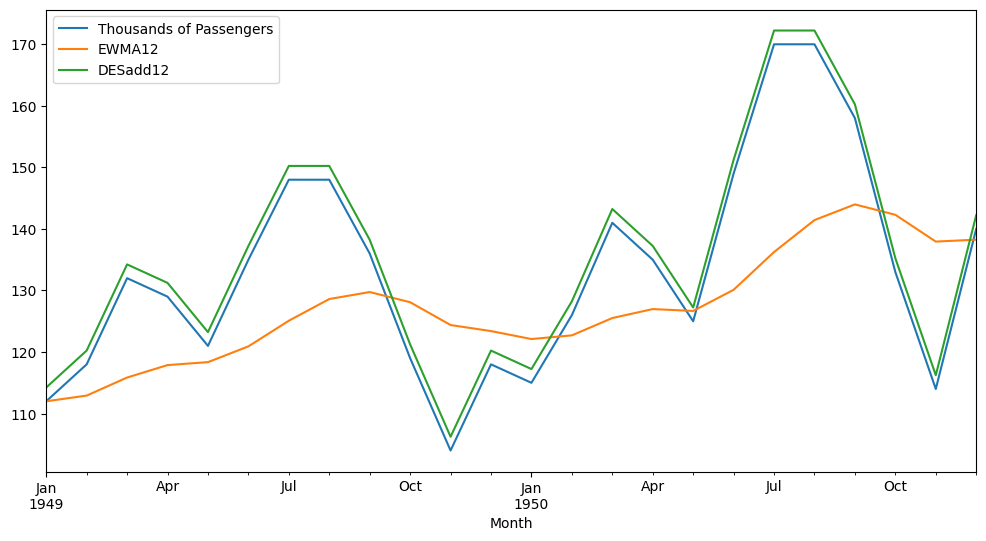

In [ ]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Aquí podemos ver que con el suavizado exponencial doble obtenemos una mejor representación de los datos. Veamos si usar un ajuste estacional multiplicativo ayuda.

In [ ]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.237756,112.049184
1949-02-01,118,112.923077,112.923077,120.237756,118.051819
1949-03-01,132,115.857988,115.857988,134.237756,132.057967
1949-04-01,129,117.879836,117.879836,131.237756,129.056650
1949-05-01,121,118.359861,118.359861,123.237756,121.053136


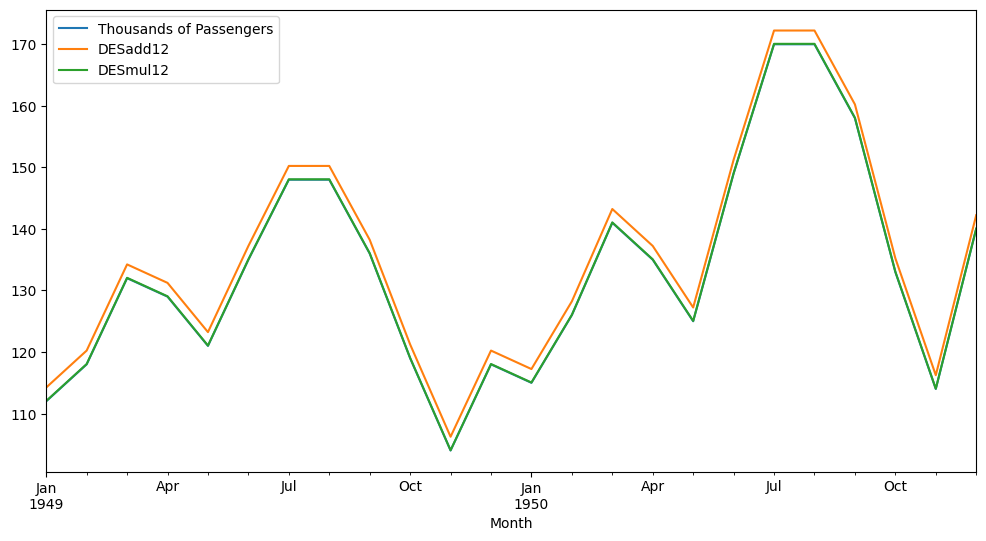

In [ ]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6));

Aunque se obtienen valores un poco menores que los valores reales, parece que un ajuste multiplicativo da mejores resultados teniendo en cuenta que la línea verde se superpone casi por completo a los datos originales.

___
## Suavizado exponencial triple
Suavizado exponencial triple o Holt-Winters, añade soporte para la tendencia y la estacionalidad.



In [ ]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.237756,112.049184,111.932942
1949-02-01,118,112.923077,112.923077,120.237756,118.051819,120.109897
1949-03-01,132,115.857988,115.857988,134.237756,132.057967,134.660048
1949-04-01,129,117.879836,117.879836,131.237756,129.056650,131.353589
1949-05-01,121,118.359861,118.359861,123.237756,121.053136,124.619547


In [ ]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.237756,112.049184,111.932942,111.595456
1949-02-01,118,112.923077,112.923077,120.237756,118.051819,120.109897,118.843524
1949-03-01,132,115.857988,115.857988,134.237756,132.057967,134.660048,133.333188
1949-04-01,129,117.879836,117.879836,131.237756,129.056650,131.353589,127.901347
1949-05-01,121,118.359861,118.359861,123.237756,121.053136,124.619547,120.978801


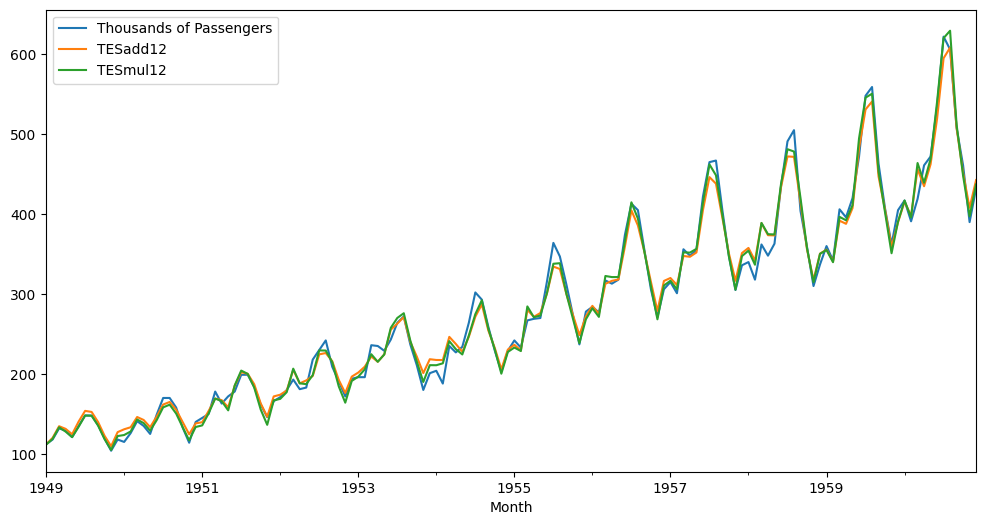

In [ ]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6));

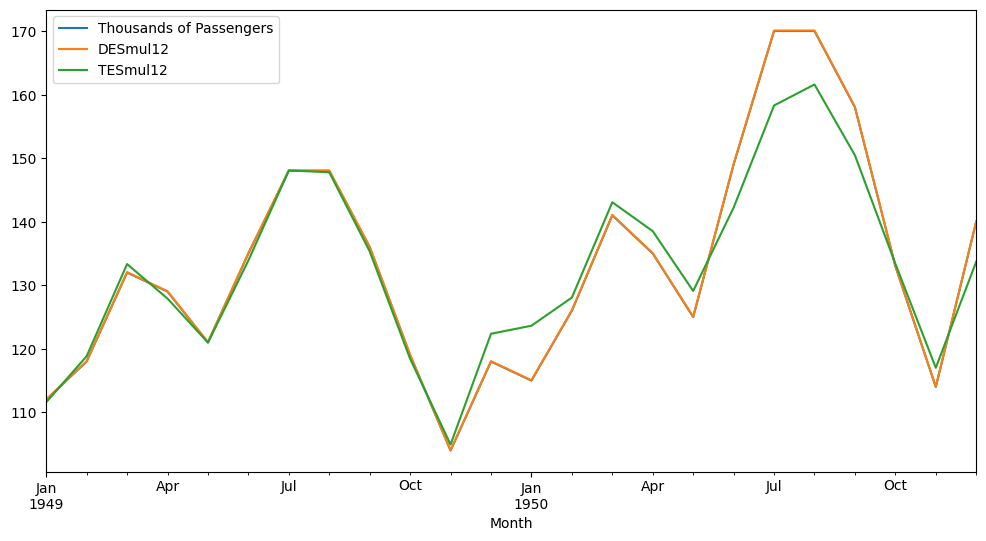

In [ ]:
df[['Thousands of Passengers','DESmul12','TESmul12']].iloc[:24].plot(figsize=(12,6));

## Predicciones sobre el futuro

Para realizar predicciones con la librería Exponential Smoothing guardamos los modelos ajustados con la función `fit(`)  y luego los invocamos con la función `forecast()`

In [ ]:
model_add = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
model_mul = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast_add = model_add.forecast(36)
forecast_mul= model_mul.forecast(36)

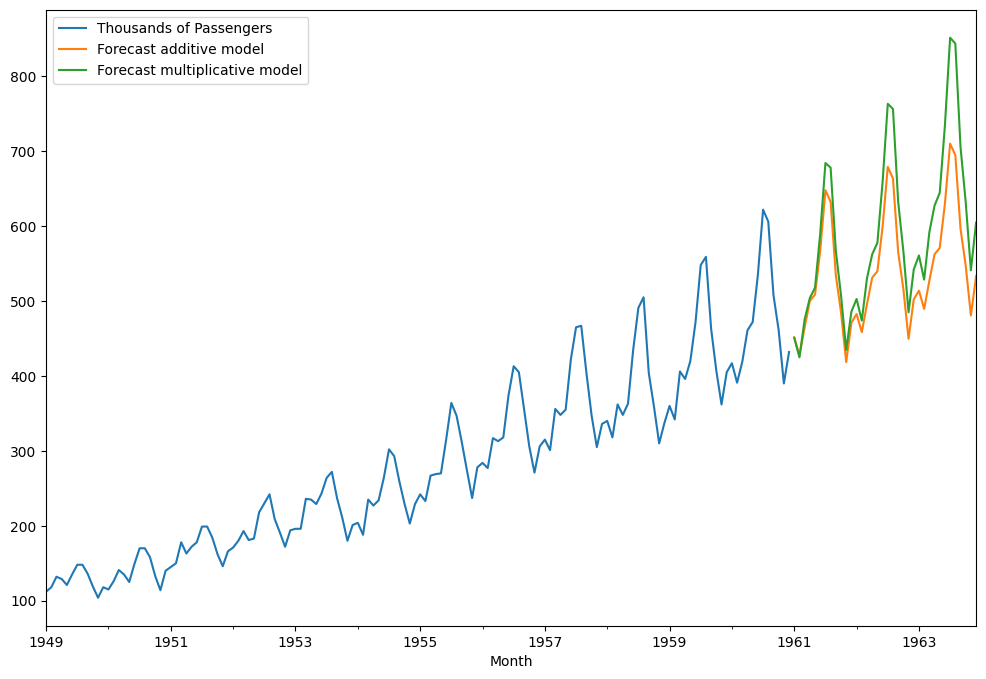

In [ ]:
import matplotlib.pyplot as plt

df['Thousands of Passengers'].plot(figsize=(12,8))
forecast_add.plot(label='Forecast additive model');
forecast_mul.plot(label='Forecast multiplicative model');
plt.legend(loc='upper left')

In [ ]:
df.isna().sum()

,0
Thousands of Passengers,0
EWMA12,0
SES12,1
DESadd12,1
DESmul12,1
TESadd12,0
TESmul12,0


## Métricas para comparar

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# Drop rows with NaN values before calculating RMSE
df_cleaned = df.dropna(subset=['Thousands of Passengers', 'DESmul12'])

error = root_mean_squared_error(df_cleaned['Thousands of Passengers'], df_cleaned['DESmul12'])
print(f'Error RMSE DESmul12: {error:11.10}')
R2=r2_score(df_cleaned['Thousands of Passengers'], df_cleaned['DESmul12'])
print(f'Ajuste R2 DESmul12: {R2:11.2}')

Error RMSE DESmul12: 0.1333459497
Ajuste R2:         1.0


In [ ]:
error = root_mean_squared_error(df_cleaned['Thousands of Passengers'], df_cleaned['TESmul12'])
print(f'Error RMSE TESmul12: {error:11.10}')

R2=r2_score(df_cleaned['Thousands of Passengers'], df_cleaned['TESmul12'])
print(f'Ajuste R2 TESmul12: {R2:11.2}')

Error RMSE TESmul12: 10.50433936
Ajuste R2 TESmul12:        0.99


# EOF